In [263]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Download file

In [2]:
file_id = "1atOZX3YXmxx-_QebbTfndeC6U_DPTL2e" # ID of the file on Google Drive
file_name = 'Updated_data_2021&2022.csv'

%run download.ipynb

# Import data

In [3]:
# File path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_path = os.path.join(parent_dir, 'Data',file_name)

df = pd.read_csv(file_path)
df.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,2021-01-01,Fri,13154,67.0,65+,M,11846,WA,37.0,NaN,1081.0,NaN,1118.0,443.55,271.254275,288
1,2021-01-01,Fri,18379,54.0,45-54,M,1884,WA,40.0,NaN,NaN,NaN,40.0,0.00,40.000000,1
2,2021-01-01,Fri,559232,63.0,55-64,M,2866,WA,NaN,NaN,12.0,NaN,12.0,9.50,2.041720,5
3,2021-01-01,Fri,698904,69.0,65+,M,2100,WA,NaN,NaN,1223.5,NaN,1223.5,267.91,245.117147,40
4,2021-01-01,Fri,762921,67.0,65+,M,4766,WA,NaN,NaN,17.5,NaN,17.5,0.00,3.504075,5


In [4]:
# DATE_DIM: datetime
df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

# BET_ACCOUNT_NUM_HASH: string
df['BET_ACCOUNT_NUM_HASH'] = df['BET_ACCOUNT_NUM_HASH'].astype('O')

# Fillna
df['AGE'].fillna(44, inplace=True)

# drop
df.drop(['DAY_OF_WEEK', 'AGE'], axis=1, inplace=True)

# More than zero
df = df[df['TOTAL_TURNOVER'] > 0]

In [50]:
df['YEAR_WEEK'] = df['DATE_DIM'].dt.year * 100 + df['DATE_DIM'].dt.week

df['RACING_TURNOVER'] = df[['FOB_RACING_TURNOVER', 'PARI_RACING_TURNOVER']].sum(axis=1)

df['WIN_LOSS'] = (df['DIVIDENDS_PAID'] >= df['TOTAL_TURNOVER']).astype('int32')

In [232]:
def weekly_aggregate(df, year_week, n_weeks = 4):
    pred = df[ (df['YEAR_WEEK'] > year_week ) & (df['YEAR_WEEK'] <= year_week + 4 ) ].groupby('BET_ACCOUNT_NUM_HASH').TOTAL_TURNOVER.sum()
    
    train = df[(df['YEAR_WEEK'] > year_week-4 ) & (df['YEAR_WEEK'] <= year_week)].groupby('BET_ACCOUNT_NUM_HASH').agg({
        'BET_ACCOUNT_NUM_HASH': np.size,
        'AGE_BAND' : max,
        'GENDER' : max,
        'TENURE_IN_DAYS' : max,
        'RACING_TURNOVER' : sum,
        'TOTAL_TURNOVER' : sum,
        'TICKETS' : sum,
        'WIN_LOSS' : sum
    })
    
    train = train[train['TENURE_IN_DAYS'] >= n_weeks * 4]
                                                 
    train = pd.merge(train, pred, left_index=True, right_index=True, how='left')

    train.columns = ['FREQ', 'AGE_BAND', 'GENDER', 'TENURE_IN_DAYS', 'RACING_TURNOVER', 'TOTAL_TURNOVER_' + str(n_weeks*7), 'TICKETS', 'WIN_LOSS', 'TOTAL_TURNOVER']
                                                   
    train['WIN_LOSS_RATIO'] = train['WIN_LOSS'] / (train['FREQ']) 
    train['FREQ'] = train['FREQ'] / n_weeks * 4
    train['RACING_RATIO'] = train['RACING_TURNOVER'] / train['TOTAL_TURNOVER_' + str(n_weeks*7)]
    train['TOTAL_TURNOVER'].fillna(0,inplace=True)
                                                 
    return train

In [233]:
train = weekly_aggregate(df, year_week= 202111, n_weeks = 4)

In [235]:
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse

lst = ['AGE_BAND', 'GENDER', 'TENURE_IN_DAYS', 'RACING_TURNOVER', 'WIN_LOSS','WIN_LOSS_RATIO', 'RACING_RATIO', 'TOTAL_TURNOVER']

X = train.drop(lst, axis=1).to_numpy()
y = train['TOTAL_TURNOVER'].to_numpy().reshape(-1,1)

X = sm.add_constant(X)

model = sm.OLS(y, X) 
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                 1.856e+04
Date:                Thu, 22 Jun 2023   Prob (F-statistic):               0.00
Time:                        17:10:46   Log-Likelihood:            -4.9717e+05
No. Observations:               51802   AIC:                         9.943e+05
Df Residuals:                   51798   BIC:                         9.944e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4465     24.321      4.459      0.000      60.778     156.115
x1            36.3427      2.305     15.765      0.000      31.824      40.861
x2             0.6623      0.003    213.847      0.000       0.656       0.668
x3             0.1482      0.030      4.933      0.000       0.089       0.207
==============================================================================
Omnibus:                    87544.417   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2539189589.886
Skew:                          10.272   Prob(JB):                         0.00
Kurtosis:                    1087.431   Cond. No.                     8.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

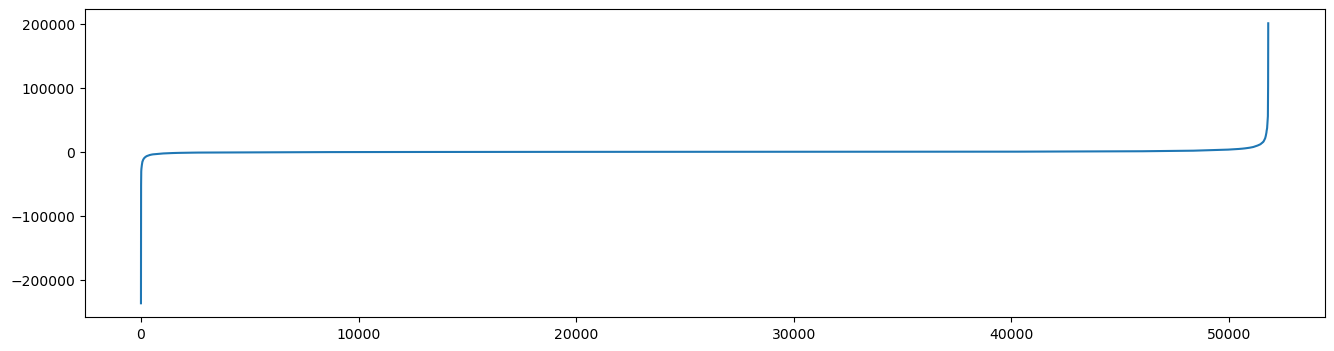

In [236]:
y_pred = results.predict(X)

e = y.flatten()  - y_pred

e.sort()

plt.figure(figsize=(16,4))
plt.plot(e )

C:\Users\duc.nguyen\AppData\Local\Temp\ipykernel_16900\848211138.py:3: RuntimeWarning: divide by zero encountered in divide
  e_per = abs(e)/y.flatten()


(0.0, 100.0)

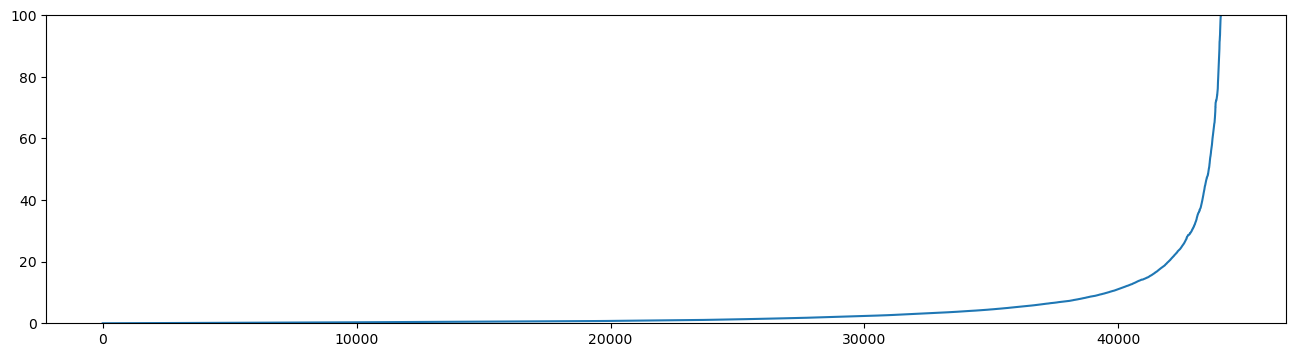

In [239]:
y_pred = results.predict(X)
e = y.flatten()  - y_pred
e_per = abs(e)/y.flatten()
e_per.sort()

plt.figure(figsize=(16,4))
plt.plot(e_per )
plt.ylim(0,100)

In [240]:
e = y.flatten()  - y_pred

In [241]:
e

array([14611.47529138,  -279.14542463,  2198.45779231, ...,
        -161.95891451,  2209.53033392, -1325.8404888 ])

In [242]:
train.iloc[abs(e) > 100000, :]

,FREQ,AGE_BAND,GENDER,TENURE_IN_DAYS,RACING_TURNOVER,TOTAL_TURNOVER_28,TICKETS,WIN_LOSS,TOTAL_TURNOVER,WIN_LOSS_RATIO,RACING_RATIO
BET_ACCOUNT_NUM_HASH,,,,,,,,,,,
326600861,21.0,45-54,M,2533,0.00,69820.00,81,7,163695.0,0.333333,0.000000
442011293,16.0,25-34,M,2129,0.00,44331.00,24,3,222150.0,0.187500,0.000000
525598846,28.0,35-44,U,265,9335.00,146750.00,159,12,299119.0,0.428571,0.063612
1025496080,28.0,25-34,M,348,1674.00,564150.00,796,14,137763.0,0.500000,0.002967
2179416580,25.0,35-44,M,3054,16207.02,16337.02,827,3,115314.7,0.120000,0.992043
3628686418,15.0,55-64,M,298,0.00,83745.00,53,13,242025.0,0.866667,0.000000
3783399434,15.0,35-44,U,138,0.00,21474.00,154,8,148665.5,0.533333,0.000000
3962433512,3.0,35-44,M,2528,3220.33,8247.33,26,2,148390.0,0.666667,0.390469


In [270]:
X = train.drop(lst, axis=1).to_numpy()
y = train['TOTAL_TURNOVER'].to_numpy()

In [276]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [277]:
lr_model = LinearRegression(fit_intercept=True)
lr_model.fit(X_train,y_train)

LinearRegression()

In [280]:
mean_squared_error(y_test, y_pred)

19836754.379007462

In [281]:
r2_score(y_pred, y_test)

0.4639330872701499

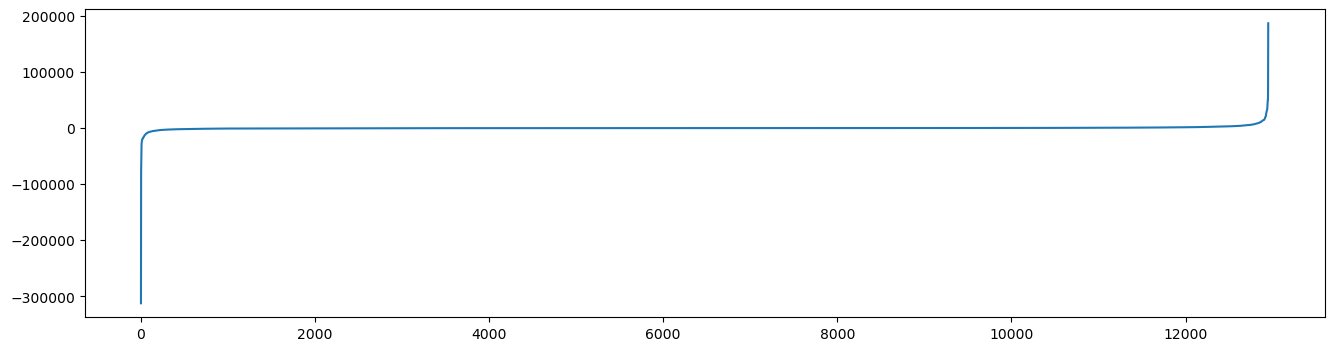

In [283]:
y_pred = lr_model.predict(X_test)
e = y_test.flatten()  - y_pred

e.sort()

plt.figure(figsize=(16,4))
plt.plot(e )

C:\Users\duc.nguyen\AppData\Local\Temp\ipykernel_16900\1241634379.py:2: RuntimeWarning: divide by zero encountered in divide
  e_per = abs(e)/y_test.flatten()


(0.0, 100.0)

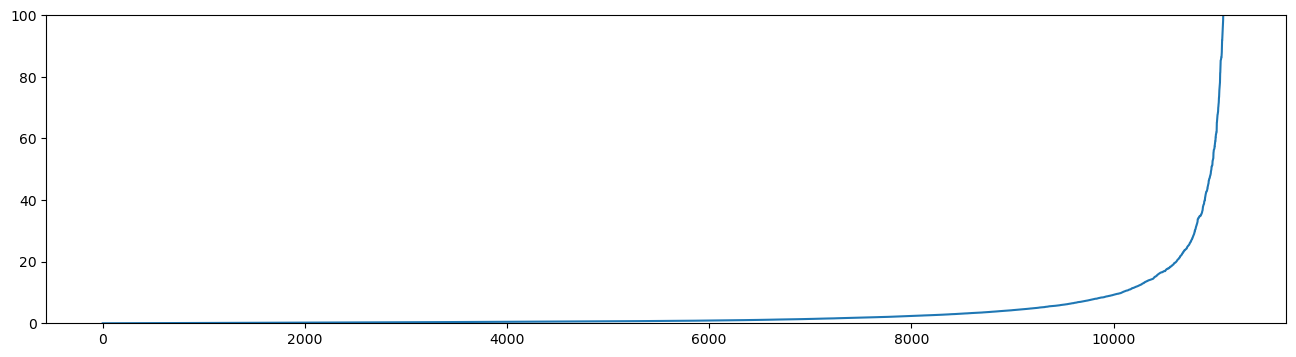

In [291]:
e = y_test.flatten()  - y_pred
e_per = abs(e)/y_test.flatten()
e_per.sort()

plt.figure(figsize=(16,4))
plt.plot(e_per )
plt.ylim(0,100)

In [288]:
(e_per <=20).sum() / y_test.shape[0]

0.8200911126553934

In [293]:
np.corrcoef(X)

MemoryError: Unable to allocate 20.0 GiB for an array with shape (51802, 51802) and data type float64

In [294]:
X

array([[2.000000e+01, 1.509175e+04, 5.218000e+03],
       [7.000000e+00, 1.319000e+03, 2.500000e+01],
       [5.000000e+00, 6.015000e+02, 9.970000e+02],
       ...,
       [1.000000e+00, 2.570000e+01, 1.000000e+00],
       [1.600000e+01, 4.223000e+03, 9.500000e+01],
       [2.000000e+01, 1.234160e+03, 5.340000e+02]])

In [256]:
test = df[(df['BET_ACCOUNT_NUM_HASH'] == 442011293) & (df['YEAR_WEEK'] >= 202107) & (df['YEAR_WEEK'] <= 202115)]

In [257]:
test.index = test['DATE_DIM']

<Axes: xlabel='DATE_DIM'>

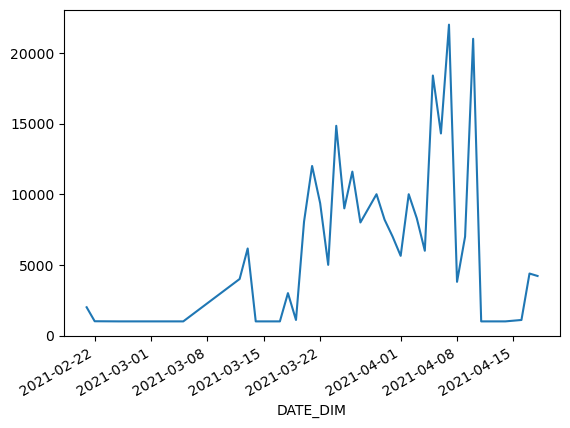

In [258]:
test['TOTAL_TURNOVER'].plot()